# Project 19 - Image compaction with autoencoder

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
dataset_train = datasets.MNIST('Datasets/MNIST', train=True, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3645902.60it/s]


Extracting Datasets/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to Datasets/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 212318.36it/s]


Extracting Datasets/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to Datasets/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1536408.27it/s]


Extracting Datasets/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5291813.55it/s]

Extracting Datasets/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/MNIST/MNIST/raw



In [3]:
dataset_val = datasets.MNIST('Datasets/MNIST', train=False, download=True, transform=transforms.ToTensor())

val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=256, shuffle=True)

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.dense0 = nn.Linear(in_features=784, out_features=32)
        self.activation0 = nn.ReLU()

        self.dense1 = nn.Linear(in_features=32, out_features=784)
        self.activation1 = nn.Sigmoid()

    def forward(self, X):
        X = X.view(-1, 28*28)
        X = self.dense0(X)
        X = self.activation0(X)

        X = self.dense1(X)
        X = self.activation1(X)

        return X

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
model = autoencoder()
model.to(device)

autoencoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
for epoch in range(10):
    running_loss_train = 0.

    for data in train_loader:
        model.train()
        
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()

        optimizer.step()

        running_loss_train += loss.item()

    running_loss_val = 0.

    for data in val_loader:
        model.eval()
        
        inputs, _ = data
        inputs = inputs.to(device)

        outputs = model.forward(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))

        running_loss_val += loss.item()
    
    print(f'Epoch {epoch+1}/{3} - Loss Train: {running_loss_train/len(train_loader)} - Loss Val: {running_loss_val/len(val_loader)}')
    

Epoch 1/3 - Loss Train: 0.14116665315120777 - Loss Val: 0.13479444459080697
Epoch 2/3 - Loss Train: 0.13156440258026122 - Loss Val: 0.12612756360322236
Epoch 3/3 - Loss Train: 0.124659899891691 - Loss Val: 0.12062294613569975
Epoch 4/3 - Loss Train: 0.11978923694250432 - Loss Val: 0.1166579706594348
Epoch 5/3 - Loss Train: 0.1163676217198372 - Loss Val: 0.11346602700650692
Epoch 6/3 - Loss Train: 0.11399057171446211 - Loss Val: 0.11156553588807583
Epoch 7/3 - Loss Train: 0.1123730130652164 - Loss Val: 0.11005387976765632
Epoch 8/3 - Loss Train: 0.11131190584695086 - Loss Val: 0.1094230879098177
Epoch 9/3 - Loss Train: 0.11064497650937831 - Loss Val: 0.10877123437821865
Epoch 10/3 - Loss Train: 0.11014859146894293 - Loss Val: 0.10852927844971419


In [10]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [11]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.dense0 = list(model.children())[0]
        self.activation0 = list(model.children())[1]

    def forward(self, X):
        X = X.view(-1, 28*28)
        X = self.dense0(X)
        X = self.activation0(X)

        return X

In [12]:
model1 = encoder()
model1.to(device)

encoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
)

In [13]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.dense1 = list(model.children())[2]
        self.activation1 = list(model.children())[3]

    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)

        return X

In [14]:
model2 = decoder()
model2.to(device)

decoder(
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [15]:
images = 10

test_image = next(iter(train_loader))[0][:images].to(device)

In [18]:
test_image.shape

torch.Size([10, 1, 28, 28])

In [16]:
model1.eval()

encoded = model1(test_image)

In [17]:
encoded.shape

torch.Size([10, 32])

In [19]:
model2.eval()

decoded = model2(encoded)

In [20]:
decoded.shape

torch.Size([10, 784])

In [22]:
test_image = test_image.detach().cpu().numpy().reshape(-1, 28, 28)
encoded = encoded.detach().cpu().numpy().reshape(-1, 8, 4)
decoded = decoded.detach().cpu().numpy().reshape(-1, 28, 28)

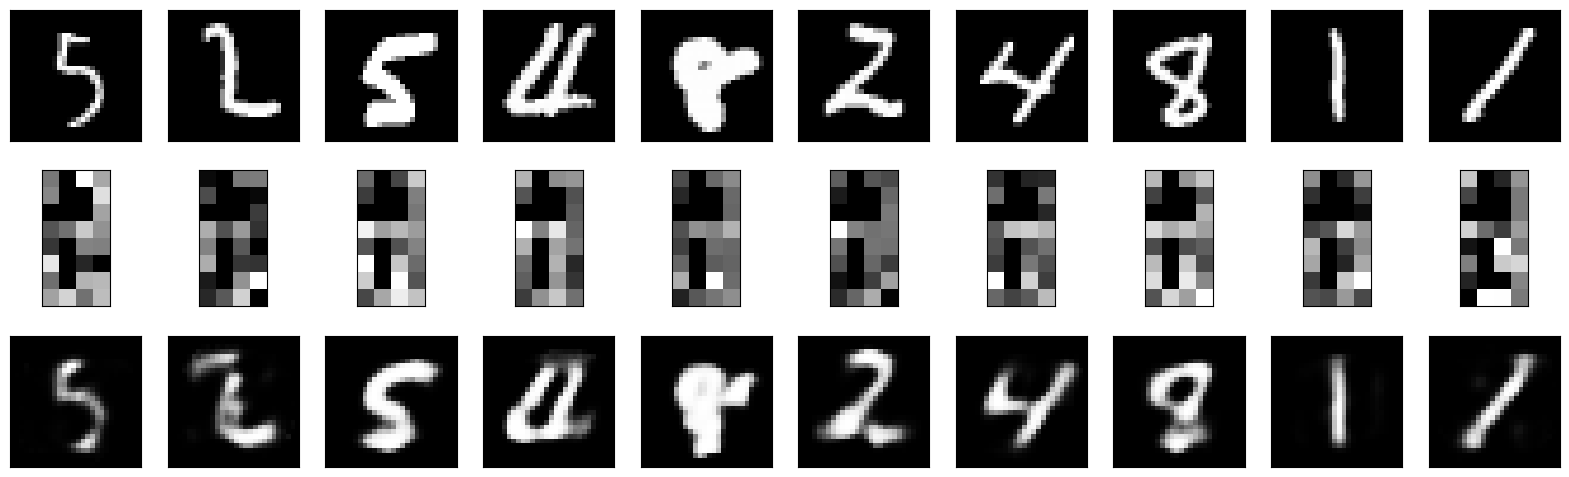

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=images, figsize=(20, 6))

for i, ax_row in zip([test_image, encoded, decoded], axes):
    for img, ax in zip(i, ax_row):
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
